In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.integrate
import scipy.interpolate
import numpy as np
import scipy.stats as sts

n0 = 0.16 #MeV/fm^3
pi = np.pi
MeV_to_km = 1.323e-6

In [2]:
EOS_small = pd.read_table('data/EOSCEFTVE1.dat', header=None).to_numpy()

We are going to extend this table through the speed of sound. We are using the speed of sound because of it's definition:

$$ c_s^2 = \frac{\partial p(\epsilon)}{\partial \epsilon} $$

The mechanics will work like Ingo et. al. where we step the baryon density, $n$, by a small $\Delta n$,

$$ n_{i+1} = n_i + \Delta n $$

where $i$ is the index of our data array. Then we use the speed of sound, $c_s$, and a thermodynamic identity to get the energy density and pressure.

$$
\begin{align}
    \epsilon_{i+1} &= \epsilon_i + \Delta n \left( \frac{\epsilon_i + p_i}{n_i} \right)\\
    p_{i+1} &= p_i + c_s^2(n_i) \Delta n \left( \frac{\epsilon_i + p_i}{n_i} \right)
\end{align}
$$
    
We will be defining our speed of sound curve in this notebook by specifying its value at a number of points and just connecting the two with linear segments. The speed of sound (in units where c=1) must be between 0 and 1 to keep causality.

To begin, let's get the speed of sound in the range we already have (n < 2n0).

In [9]:
n = EOS_small[:,0] 
p = EOS_small[:,1] 
e = EOS_small[:,2] 

# derivative of pressure wrt energy
dp_de = scipy.interpolate.CubicSpline(p, e).derivative(nu=1)

#definition of speed of sound
c_s_2n0 = np.sqrt(1/dp_de(p[-1]))
print(n)

[4.00000001e-15 4.73000011e-15 4.75999990e-15 ... 3.19600000e-01
 3.19800000e-01 3.20000000e-01]


In [4]:
def sample_cs(num_points, max_n, n_start, cs_start):
    
    # sample random points in density
    epsilon = 1e-17
    loc_n = n_start + epsilon #to guarentee we don't randomly pull n_start
    scale_n = max_n - n_start - epsilon
    sample_n = sts.uniform.rvs(loc=loc_n, scale=scale_n, size=num_points-1)
    # order these points
    n_sort = np.sort(sample_n)
    
    # sample speeds of sound
    sample_cs = sts.uniform.rvs(size=num_points)
    
    # construct the arrays
    n_0 = n_start*np.ones(1)
    n = np.append(n_0, n_sort)
    ns = np.append(n, max_n)
    
    c_0 = cs_start*np.ones(1)
    cs = np.append(c_0, sample_cs)
    
    return ns, cs

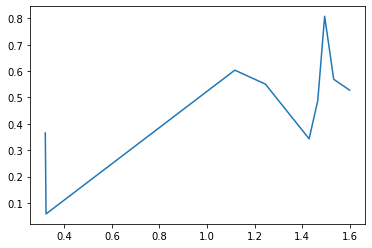

In [5]:
num_points = 8
n_start = n[-1]
max_n = 10*n0

ns, cs = sample_cs(num_points, max_n, n_start, c_s_2n0)

cs2_lin = scipy.interpolate.interp1d(ns, cs)

plt.plot(ns, cs2_lin(ns))

In [6]:
def extend_EOS_cs(n_step, cs2_func):

    size = int((max_n-n_start)/n_step)

    # initialize array
    EOS_ex = np.zeros((size, 3))
    # set starting values at n = 2n0
    EOS_ex[0,0] = n_start
    EOS_ex[0,1] = p[-1]
    EOS_ex[0,2] = e[-1]

    for k in range(size-1):
        # n_i+1
        EOS_ex[k+1,0] = EOS_ex[k,0] + n_step
        # p_i+1
        if cs2_func(EOS_ex[k,0]) > 1:
            EOS_ex[k+1,1] = EOS_ex[k,1] + n_step*((EOS_ex[k,1]+EOS_ex[k,2])/EOS_ex[k,0])
        else:
            EOS_ex[k+1,1] = EOS_ex[k,1] + n_step*(cs2_func(EOS_ex[k,0]))*((EOS_ex[k,1]+EOS_ex[k,2])/EOS_ex[k,0])
        # e_i+1
        EOS_ex[k+1,2] = EOS_ex[k,2] + n_step*((EOS_ex[k,1]+EOS_ex[k,2])/EOS_ex[k,0])
        
    return EOS_ex

def extend_EOS_lin(n_step, ns, cs2):

    size = int((max_n-n_start)/n_step)

    # initialize array
    EOS_ex = np.zeros((size, 3))
    # set starting values at n = 2n0
    EOS_ex[0,0] = n_start
    EOS_ex[0,1] = p[-1]
    EOS_ex[0,2] = e[-1]

    i=0
    
    for k in range(size-1):
        # n_i+1
        EOS_ex[k+1,0] = EOS_ex[k,0] + n_step
        # p_i+1
        if ns[i] <= EOS_ex[k,0] < ns[i+1]:
            EOS_ex[k+1,1] = EOS_ex[k,1] + n_step*cs2[i]*((EOS_ex[k,1]+EOS_ex[k,2])/EOS_ex[k,0])
        else:
            i +=1
            EOS_ex[k+1,1] = EOS_ex[k,1] + n_step*cs2[i]*((EOS_ex[k,1]+EOS_ex[k,2])/EOS_ex[k,0])
        # e_i+1
        EOS_ex[k+1,2] = EOS_ex[k,2] + n_step*((EOS_ex[k,1]+EOS_ex[k,2])/EOS_ex[k,0])
        
    return EOS_ex

def stitch_EOS(small_EOS, EOS_ex):
    
    # get relevant sizes
    size_smol = small_EOS.shape[0] -1 # -1 becuase we don't want last duplicated entry
    size_ex = EOS_ex.shape[0]
    
    # initialize array
    tot_EOS = np.zeros((size_smol+size_ex, small_EOS.shape[1]))
    
    tot_EOS[:size_smol,:] = small_EOS[:size_smol,:]
    tot_EOS[size_smol:,0] = EOS_ex[:,0]
    tot_EOS[size_smol:,1] = EOS_ex[:,1]
    tot_EOS[size_smol:,2] = EOS_ex[:,2]
    
    return tot_EOS

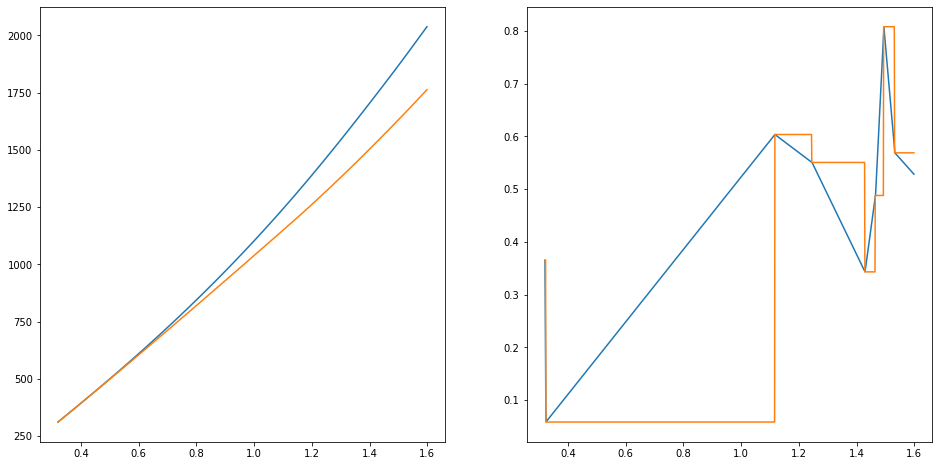

In [11]:
n_step = 1e-3

cs_ex = extend_EOS_cs(n_step, cs2_lin)
cs_EOS = stitch_EOS(EOS_small, cs_ex)

lin_ex = extend_EOS_lin(n_step, ns, cs)
lin_EOS = stitch_EOS(EOS_small, lin_ex)

size = int((max_n - n[-1])/n_step)
cs_flat = np.zeros(size)

density = n[-1]
j = 0
for i in range(size):
    density += n_step
    if ns[j] <= density < ns[j+1]:
        cs_flat[i] = cs[j]
    else:
        j += 1
        cs_flat[i] = cs[j]

fig, ax = plt.subplots(1,2, figsize=(16,8))

ax[0].plot(cs_ex[:,0], cs_ex[:,2], '-')
ax[0].plot(lin_ex[:,0], lin_ex[:,2], '-')

ax[1].plot(cs_ex[:,0], cs2_lin(cs_ex[:,0]))
ax[1].plot(lin_ex[:,0], cs_flat)

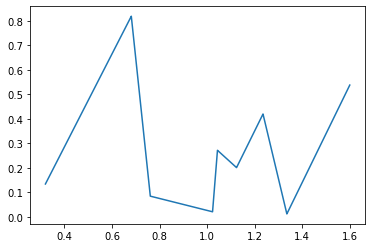

In [22]:
plt.plot(EOS_lin_ex[:,0], cs2_lin(EOS_lin_ex[:,0]))

In [23]:
import real_TOVsolver

max_pressure = 350 #MeV/fm3

MRL_lin = real_TOVsolver.solve(tot_EOS_lin, max_pressure)
np.savetxt('data/MRL_lin.dat', MRL_lin)

/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


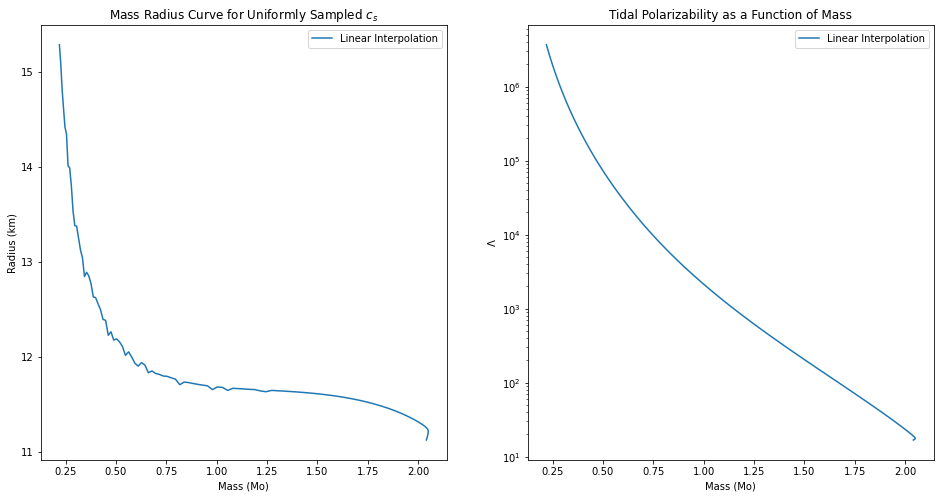

In [24]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

ax[0].plot(MRL_lin[:,0], MRL_lin[:,1], label='Linear Interpolation')
# ax[0].plot(MRL_cube[:,0], MRL_cube[:,1], label='Cubic Spline Interpolation')
ax[0].set_xlabel('Mass (Mo)')
ax[0].set_ylabel('Radius (km)')
ax[0].set_title('Mass Radius Curve for Uniformly Sampled $c_s$')
ax[0].legend()

ax[1].plot(MRL_lin[:,0], MRL_lin[:,2], label='Linear Interpolation')
# ax[1].plot(MRL_cube[:,0], MRL_cube[:,2], label='Cubic Spline Interpolation')
ax[1].set_xlabel('Mass (Mo)')
ax[1].set_ylabel('$\Lambda$')
ax[1].set_yscale('log')
ax[1].set_title('Tidal Polarizability as a Function of Mass')
ax[1].legend()

We want an interpolation method that also makes linear segments in the pressure $P(\epsilon)$. We can borrow the same idea we used to make linear segments in the speed of sound, pull random density points but also pull random pressures and sort them from loweset to highest (because we can't have the pressure decreasing).

In [25]:
def sample_P(num_points, n_start, max_n, p_start, max_p):
    
    # sample random points in density
    epsilon_n = 1e-7*n_start
    loc_n = n_start + epsilon_n #to guarentee we don't randomly pull n_start
    scale_n = max_n - n_start - epsilon_n
    sample_n = sts.uniform.rvs(loc=loc_n, scale=scale_n, size=num_points-1)
    # order these points
    n_sort = np.sort(sample_n)
    
    # sample speeds of sound
    epsilon_p = 1e-7*p_start
    loc_p = p_start + epsilon_p #to guarentee we don't randomly pull p_start
    scale_p = max_p - p_start - epsilon_p
    sample_p = sts.uniform.rvs(loc=loc_p, scale=scale_p, size=num_points-1)
    # order these points
    p_sort = np.sort(sample_p)
    
    # construct the arrays
    n_0 = n_start*np.ones(1)
    n = np.append(n_0, n_sort)
    ns = np.append(n, max_n)
    
    p_0 = p_start*np.ones(1)
    p = np.append(p_0, p_sort)
    ps = np.append(p, max_p)
    
    return ns, ps

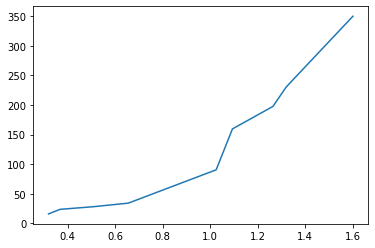

In [26]:
# parameters for sampling function
num_points = 8
n_start = n[-1]
max_n = 10*n0
p_start = p[-1]
max_p = max_pressure

ns, ps = sample_P(num_points, n_start, max_n, p_start, max_p)

P_lin = scipy.interpolate.interp1d(ns, ps)

plt.plot(ns, P_lin(ns))

In [27]:
def extend_EOS_Plin(n_step, P_lin):

    size = int((max_n-n_start)/n_step)

    # initialize array
    EOS_ex = np.zeros((size, 3))
    # set starting values at n = 2n0
    EOS_ex[0,0] = n_start
    EOS_ex[0,1] = p[-1]
    EOS_ex[0,2] = e[-1]

    for k in range(size-1):
        # n_i+1
        EOS_ex[k+1,0] = EOS_ex[k,0] + n_step
        # p_i+1
        EOS_ex[k+1,1] = P_lin(EOS_ex[k+1,0])
        # e_i+1
        EOS_ex[k+1,2] = EOS_ex[k,2] + n_step*((EOS_ex[k,1]+EOS_ex[k,2])/EOS_ex[k,0])
        
    return EOS_ex

In [28]:
EOS_linP_ex = extend_EOS_Plin(1e-3, P_lin)
EOS_linP = stitch_EOS(EOS_small, EOS_linP_ex)

MRL_linP = real_TOVsolver.solve(EOS_linP, max_pressure)
np.savetxt('data/MRL_linP.dat', MRL_linP)

/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


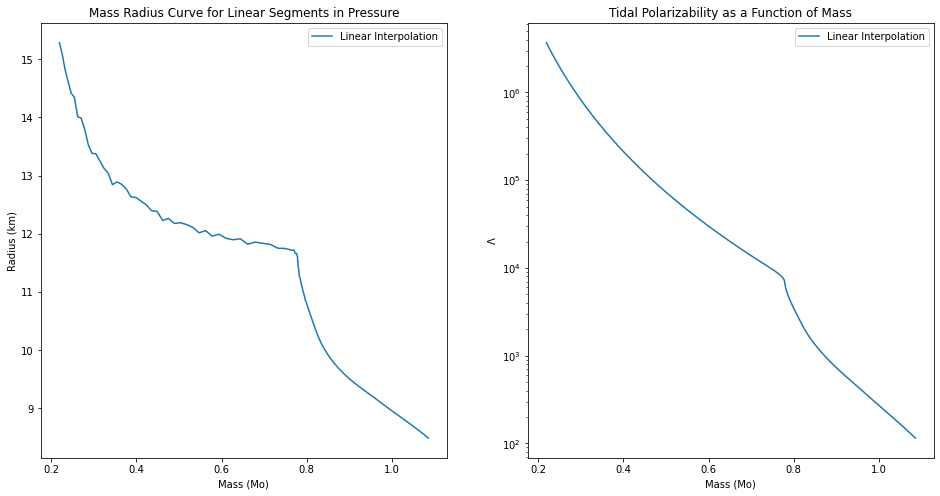

In [29]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

ax[0].plot(MRL_linP[:,0], MRL_linP[:,1], label='Linear Interpolation')
ax[0].set_xlabel('Mass (Mo)')
ax[0].set_ylabel('Radius (km)')
ax[0].set_title('Mass Radius Curve for Linear Segments in Pressure')
ax[0].legend()

ax[1].plot(MRL_linP[:,0], MRL_linP[:,2], label='Linear Interpolation')
ax[1].set_xlabel('Mass (Mo)')
ax[1].set_ylabel('$\Lambda$')
ax[1].set_yscale('log')
ax[1].set_title('Tidal Polarizability as a Function of Mass')
ax[1].legend()

Next we also want to implement segments of polytropic equations ($P = K\rho^\Gamma$). Here is the strategy I have so far: We will do the same idea as the above ideas, where we randomly pull a number of density points between the start and max then sort them. Then we can pull the same number of $\Gamma_i$ parameters and one $K_1$. The rest of the $K_i$ values will be used to make the EOS continuous. Say we have two pressure segments $P_1$ and $P_2$ at the density point where they match $\rho_1$. If we require the two to match we have:

$$ P_1(\rho_1) = K_1 \rho_1^{\Gamma_1} = K_2 \rho_1^{\Gamma_2} = P_2(\rho_1) \quad \implies \quad K_2 = K_1 \rho_1^{\Gamma_1 - \Gamma_2} $$

Actually, because we are given the pressure up to when we start extending, we need to use the first $K_1$ to match our extension there. In a similar argument as above, we get

$$ P(\rho_0) = K_1 \rho_0^{\Gamma_1} \quad \implies \quad K_1 = P_0 \rho_0^{-\Gamma_1} $$

Now we want to tanslate this to the stepping algorithm we used above. If we take a small step in the density, we need to calculate the step we take in pressure and energy density. If we take a derivative of the polytropic equation we get

$$ \frac{dP_i}{d\rho} = K_i \Gamma_i \rho^{\Gamma_i} \quad \implies \quad \Delta P_i = K_i \Gamma_i \rho^{\Gamma_i} \Delta \rho $$

Then using the same thermodynamic relation we get the change in energy density as

$$ \Delta \epsilon = \Delta \rho \left( \frac{\epsilon_i + P(\rho_i)}{\rho_i} \right) $$

Finally, the last thing we need to worry about is causality. Like in the speed of sound extension, we need to be sure the speed of sound is below 1.

$$ \begin{align}
c_s^2 &= \frac{\partial p(\epsilon)}{\partial \epsilon} \approx \frac{\Delta p}{\Delta \epsilon}\\
&= \frac{K_i \Gamma_i \rho_j^{\Gamma_i+1}}{\epsilon_j + K_i \rho_j^{\Gamma_i}}\\
&= \rho_j \Gamma_i \frac{K_i \rho_j^{\Gamma_i}}{\epsilon_j + K_i \rho_j^{\Gamma_i}}\\
&= \frac{K'_i \rho_j^{\Gamma_i-1}}{\epsilon'_j + K'_i \rho_j^{\Gamma_i-1}} && \epsilon'_j = \frac{\epsilon_j}{\rho_j \Gamma_i} &&& K'_i = \frac{K_i}{\Gamma_i}\\
&= 1 - \frac{\epsilon'_j}{\epsilon'_j + K'_i \rho_j^{\Gamma_i-1}}
\end{align}$$

and we can see as long as $\epsilon'_j > 0$ we are guarenteed that $c_s^2 < 1$. I will charaterize the $\Gamma$'s and the initial $K$ with a gamma distribution:

$$ f(x,a) = \frac{x^{a-1}e^x}{\Gamma(a)} $$

where $\Gamma(a)$ is the gamma function, not to be confused with our parameter. This way I can draw a set of random parameters by specifying only one hyperparmeter. For now, I will use $a_\Gamma = 5/3$ because that's the value of gamma I used for the first instance of solving the TOV equations and the parameter $a$ is the mean of the gamma distribution.

In [43]:
def sample_polytrop(num_points, n_start, max_n, p_start, a_gamma):
    # sample random points in density
    epsilon_n = 1e-5*n_start
    loc_n = n_start + epsilon_n #to guarentee we don't randomly pull n_start
    scale_n = max_n - n_start - epsilon_n
    sample_n = sts.uniform.rvs(loc=loc_n, scale=scale_n, size=num_points)
    # order these points
    n_sort = np.sort(sample_n)
    # construct the arrays
    n_0 = n_start*np.ones(1)
    n = np.append(n_0, n_sort)
    ns = np.append(n, max_n)
    
    # sample random gammas
    gammas = sts.gamma.rvs(a=a_gamma, size=num_points+1)
    
    # initialize K array
    K0 = p_start*(n_0**(-gammas[0]))
    K = np.zeros(num_points)
    Ks = np.append(K0, K)
    
    for i in range(num_points):
        Ks[i+1] = Ks[i]*(ns[i+1]**(gammas[i]-gammas[i+1]))
        
    return ns, gammas, Ks

In [44]:
n_test, g_test, k_test = sample_polytrop(3, n[-1], 10*n0, p[-1], 5/3)
print(n_test.shape, g_test, k_test)

(5,) [1.24983119 0.46709095 4.67078827 3.14118561] [65.88350934 32.11184504 54.56911597 70.63160301]


In [52]:
def extend_EOS_polytrop(n_step, ns, Ks, gammas):

    size = int((ns[-1]-ns[0])/n_step)

    # initialize array
    EOS_ex = np.zeros((size, 3))
    # set starting values at n = 2n0
    EOS_ex[0,0] = n[-1]
    EOS_ex[0,1] = p[-1]
    EOS_ex[0,2] = e[-1]
    
    i=0

    for k in range(size-1):
        # n_i+1
        EOS_ex[k+1,0] = EOS_ex[k,0] + n_step
        # p_i+1
        if ns[i] < EOS_ex[k+1,0] < ns[i+1]:
            EOS_ex[k+1,1] = EOS_ex[k,1] + n_step*(Ks[i]*gammas[i]*(EOS_ex[k,0]**(gammas[i])))
        else:
            print(i)
            i+=1
            EOS_ex[k+1,1] = EOS_ex[k,1] + n_step*(Ks[i]*gammas[i]*(EOS_ex[k,0]**(gammas[i])))
        # e_i+1
        EOS_ex[k+1,2] = EOS_ex[k,2] + n_step*((EOS_ex[k,1]+EOS_ex[k,2])/EOS_ex[k,0])
        
    return EOS_ex

In [53]:
poly_ext = extend_EOS_polytrop(1e-3, n_test, k_test, g_test)


0
1
2


[ 15.85980104  15.87962311  15.89952263 ... 382.50018384 383.46559238
 384.43290109]


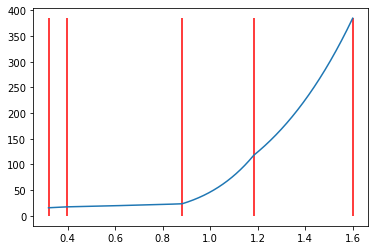

In [55]:
print(poly_ext[:,1])
plt.plot(poly_ext[:,0], poly_ext[:,1])
plt.vlines(n_test, ymin=0, ymax=np.max(poly_ext[:,1]), color='r')

In [56]:
EOS_poly = stitch_EOS(EOS_small, poly_ext)

MRL_polytrop = real_TOVsolver.solve(EOS_poly, max_pressure)
# np.savetxt('data/MRL_polytrop.dat', MRL_polytrop)

/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


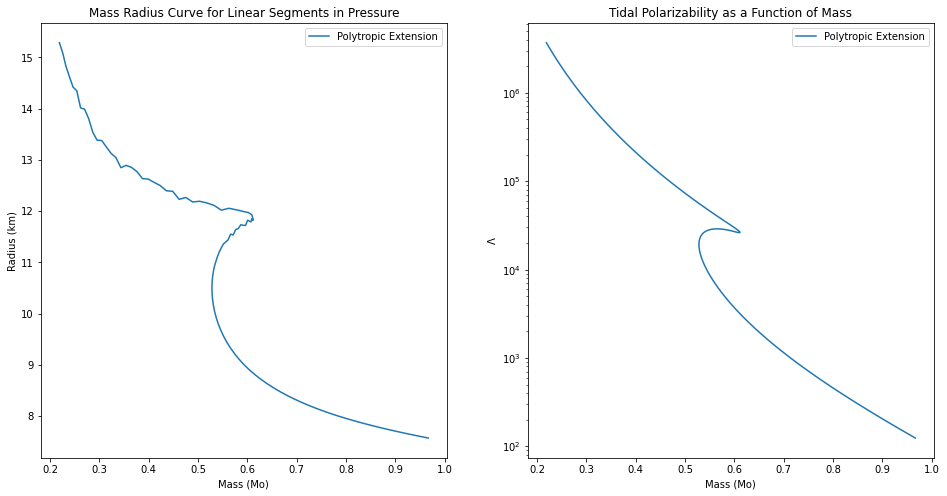

In [57]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

ax[0].plot(MRL_polytrop[:,0], MRL_polytrop[:,1], label='Polytropic Extension')
ax[0].set_xlabel('Mass (Mo)')
ax[0].set_ylabel('Radius (km)')
ax[0].set_title('Mass Radius Curve for Linear Segments in Pressure')
ax[0].legend()

ax[1].plot(MRL_polytrop[:,0], MRL_polytrop[:,2], label='Polytropic Extension')
ax[1].set_xlabel('Mass (Mo)')
ax[1].set_ylabel('$\Lambda$')
ax[1].set_yscale('log')
ax[1].set_title('Tidal Polarizability as a Function of Mass')
ax[1].legend()

In [60]:
def simulate_EOS(nsamp, small_EOS, rho_step, rho_max, ext_type, a_gamma):
    """
    Function to simulate and extend an EOS three ways
    
    inputs
    nsim: number of extensions to produce
    nsamp: number of density points to sample when making extentions
    small_EOS: the low density EOS to be extended
    rho_step: the step size in rho when extending
    rho_max: the maximum density of extension
    ext_type: the type of extension to do (speed of sound, linear P, and polytropic)
        cs (string) or 1 (int)
        linear or 2
        polytrop or 3
    a_gamma: only needed if doing polytropic extension, but characterized the distribution from
                which gamma's are drawn
                
    output
    EOS_tot = extended EOS stiched after small_EOS
    """
    n = small_EOS[:,0] 
    p = small_EOS[:,1] 
    e = small_EOS[:,2] 
    
    n0 = 0.16 #MeV/fm^3
    max_p = 350 #MeV/fm^3

    ns = sample_ns(nsamp, n[-1], rho_max)

    if ext_type == 'cs' or ext_type == 1:
        # derivative of pressure wrt energy
        dp_de = scipy.interpolate.CubicSpline(p, e).derivative(nu=1)
        
        #definition of speed of sound
        cs_start = np.sqrt(1/dp_de(p[-1]))
        
        #sample cs
        cs = sample_cs(nsamp, cs_start)
        
        # make speed of sound squared function
        cs2_func = scipy.interpolate.interp1d(ns, cs**2)
        
        # extend EOS
        EOS_ex = extend_EOS_cs(rho_step, cs2_func)
        
    elif ext_type == 'linear' or ext_type == 2:
        # sample P
        ps = sample_P(nsamp, p[-1], max_p)
        
        # make linear interpolation
        P_lin = scipy.interpolate.interp1d(ns, ps)
        
        # extend EOS
        EOS_ex = extend_Plin(rho_step, P_lin)
        
    elif ext_type == 'polytrop' or ext_type == 3:
        # sample parameters
        gammas, Ks = sample_polytrop(nsamp, ns, p[-1], a_gamma)
        
        # extend EOS
        EOS_ex = extend_EOS_polytrop(rho_step, ns, Ks, gammas)
        
    else:
        print('The ext_type you entered does not match any of the allowed types. Please enter "cs" for a ' +
              'speed of sound extension, "linear" for an extension linear in pressure and "polytop" ' +
             'for a polytropic extension')
        
    EOS_tot = stitch_EOS(small_EOS, EOS_ex)
    
    return EOS_tot

In [64]:
def sample_ns(num_points, n_start, max_n):
    
    # sample random points in density
    epsilon = 1e-17
    loc_n = n_start + epsilon #to guarentee we don't randomly pull n_start
    scale_n = max_n - n_start - epsilon
    sample_n = sts.uniform.rvs(loc=loc_n, scale=scale_n, size=num_points-1)
    # order these points
    n_sort = np.sort(sample_n)

    # construct the arrays
    n_0 = n_start*np.ones(1)
    n = np.append(n_0, n_sort)
    ns = np.append(n, max_n)
    
    return ns

def sample_cs(num_points, cs_start):
    
    # sample speeds of sound
    sample_cs = sts.uniform.rvs(size=num_points)
    
    c_0 = cs_start*np.ones(1)
    cs = np.append(c_0, sample_cs)
    
    return ns, cs

def extend_cs(n_step, cs2_func):

    size = int((max_n-n_start)/n_step)

    # initialize array
    EOS_ex = np.zeros((size, 3))
    # set starting values at n = 2n0
    EOS_ex[0,0] = n_start
    EOS_ex[0,1] = p[-1]
    EOS_ex[0,2] = e[-1]

    for k in range(size-1):
        # n_i+1
        EOS_ex[k+1,0] = EOS_ex[k,0] + n_step
        # p_i+1
        if cs2_func(EOS_ex[k,0]) > 1:
            EOS_ex[k+1,1] = EOS_ex[k,1] + n_step*((EOS_ex[k,1]+EOS_ex[k,2])/EOS_ex[k,0])
        else:
            EOS_ex[k+1,1] = EOS_ex[k,1] + n_step*(cs2_func(EOS_ex[k,0]))*((EOS_ex[k,1]+EOS_ex[k,2])/EOS_ex[k,0])
        # e_i+1
        EOS_ex[k+1,2] = EOS_ex[k,2] + n_step*((EOS_ex[k,1]+EOS_ex[k,2])/EOS_ex[k,0])
        
    return EOS_ex

def sample_P(num_points, p_start, max_p):
    
    # sample pressures
    epsilon_p = 1e-7*p_start
    loc_p = p_start + epsilon_p #to guarentee we don't randomly pull p_start
    scale_p = max_p - p_start - epsilon_p
    sample_p = sts.uniform.rvs(loc=loc_p, scale=scale_p, size=num_points-1)
    # order these points
    p_sort = np.sort(sample_p)

    p_0 = p_start*np.ones(1)
    p = np.append(p_0, p_sort)
    ps = np.append(p, max_p)
    
    return ps

def extend_Plin(n_step, P_lin):

    size = int((max_n-n_start)/n_step)

    # initialize array
    EOS_ex = np.zeros((size, 3))
    # set starting values at n = 2n0
    EOS_ex[0,0] = n_start
    EOS_ex[0,1] = p[-1]
    EOS_ex[0,2] = e[-1]

    for k in range(size-1):
        # n_i+1
        EOS_ex[k+1,0] = EOS_ex[k,0] + n_step
        # p_i+1
        EOS_ex[k+1,1] = P_lin(EOS_ex[k+1,0])
        # e_i+1
        EOS_ex[k+1,2] = EOS_ex[k,2] + n_step*((EOS_ex[k,1]+EOS_ex[k,2])/EOS_ex[k,0])
        
    return EOS_ex

def sample_polytrop(num_points, ns, p_start, a_gamma):
    n_0 = ns[0]*np.ones(1)
    
    # sample random gammas
    gammas = sts.gamma.rvs(a=a_gamma, size=num_points+1)
    
    # initialize K array
    K0 = p_start*(n_0**(-gammas[0]))
    K = np.zeros(num_points)
    Ks = np.append(K0, K)
    
    for i in range(num_points):
        Ks[i+1] = Ks[i]*(ns[i+1]**(gammas[i]-gammas[i+1]))
        
    return gammas, Ks

def extend_EOS_polytrop(n_step, ns, Ks, gammas):

    size = int((ns[-1]-ns[0])/n_step)

    # initialize array
    EOS_ex = np.zeros((size, 3))
    # set starting values at n = 2n0
    EOS_ex[0,0] = n[-1]
    EOS_ex[0,1] = p[-1]
    EOS_ex[0,2] = e[-1]
    
    i=0

    for k in range(size-1):
        # n_i+1
        EOS_ex[k+1,0] = EOS_ex[k,0] + n_step
        # p_i+1
        if ns[i] < EOS_ex[k+1,0] < ns[i+1]:
            EOS_ex[k+1,1] = EOS_ex[k,1] + n_step*(Ks[i]*gammas[i]*(EOS_ex[k,0]**(gammas[i])))
        else:
            i+=1
            EOS_ex[k+1,1] = EOS_ex[k,1] + n_step*(Ks[i]*gammas[i]*(EOS_ex[k,0]**(gammas[i])))
        # e_i+1
        EOS_ex[k+1,2] = EOS_ex[k,2] + n_step*((EOS_ex[k,1]+EOS_ex[k,2])/EOS_ex[k,0])
        
    return EOS_ex

In [65]:
nsamp = 5
rho_step = 1e-3
rho_max = 10*n0
ext_type = 'polytrop'
a_gamma = 5/3

EOS_tot = simulate_EOS(nsamp, EOS_small, rho_step, rho_max, ext_type, a_gamma)